<a href="https://colab.research.google.com/github/ParveenVats/Kaggle_prblm_instacart_markt_analysis_python/blob/master/Parveen_Instacart_redcarpet_vats_9731_gmail_com.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Instacart  Market Basket

                                                                              Parveen Kumar (vats.9731@gmail.com)

### 0. Library Import & Data Loading

In [0]:
import pandas as pd
import numpy as np
import gc # Garbage Collector interface
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from google.colab import files

In [0]:
uploaded=files.upload()


In [0]:
uploaded=files.upload()

Saving products.csv to products (1).csv


In [0]:
uploaded=files.upload()

Saving departments.csv to departments (1).csv


In [0]:
uploaded=files.upload()

Saving products.csv to products.csv


In [0]:
uploaded=files.upload()


Saving orders.csv to orders.csv


In [0]:
uploaded=files.upload()

Saving order_products__prior.csv to order_products__prior (1).csv


In [0]:
uploaded=files.upload()

Saving order_products__train.csv to order_products__train.csv


In [0]:
# data loading
aisles =pd.read_csv('./aisles.csv')
dep = pd.read_csv('./departments.csv')
ord_prd_pr = pd.read_csv('./order_products__prior.csv')
ord_prd_tr = pd.read_csv('./order_products__train.csv')
orders = pd.read_csv('./orders.csv')
products = pd.read_csv('./products.csv')

# New Section

In [0]:
products.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


In [0]:
# Changing some columns types to int for less memory usage
aisles['aisle'] = aisles['aisle'].astype('category')
dep['department'] = dep['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
#products['product_name'] = products['product_name'].astype('category')

orders.order_dow = orders.order_dow.astype(np.int8)
orders.order_hour_of_day = orders.order_hour_of_day.astype(np.int8)
orders.order_number = orders.order_number.astype(np.int16)
orders.order_id = orders.order_id.astype(np.int32)
orders.user_id = orders.user_id.astype(np.int32)
orders.days_since_prior_order = orders.days_since_prior_order.astype(np.float32)

#products.drop(['product_name'], axis=1, inplace=True)
products.aisle_id = products.aisle_id.astype(np.int8)
products.department_id = products.department_id.astype(np.int8)
products.product_id = products.product_id.astype(np.int32)

ord_prd_tr.reordered = ord_prd_tr.reordered.astype(np.int8)
ord_prd_tr.add_to_cart_order = ord_prd_tr.add_to_cart_order.astype(np.int16)

ord_prd_pr.order_id = ord_prd_pr.order_id.astype(np.int32)
#ord_prd_pr.add_to_cart_order = ord_prd_pr.add_to_cart_order.astype(np.int16)
#ord_prd_pr.reordered = ord_prd_pr.reordered.astype(np.int8)
#ord_prd_pr.product_id = ord_prd_pr.product_id.astype(np.int32)

In [0]:
print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))
print('products {}: {}'.format(products.shape, ', '.join(products.columns)))
print('ord_prd_tr {}: {}'.format(ord_prd_tr.shape, ', '.join(ord_prd_tr.columns)))
print('ord_prd_pr {}: {}'.format(ord_prd_pr.shape, ', '.join(ord_prd_pr.columns)))

orders (1048575, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
products (49688, 3): product_id, aisle_id, department_id
ord_prd_tr (1048575, 4): order_id, product_id, add_to_cart_order, reordered
ord_prd_pr (981949, 4): order_id, product_id, add_to_cart_order, reordered


### 1. EDA

#### (1)  Orders data -> prior, train, test set 

* eval_set

In [0]:
cnt_df = orders.eval_set.value_counts()
cnt_df

prior    985475
train     40096
test      23004
Name: eval_set, dtype: int64

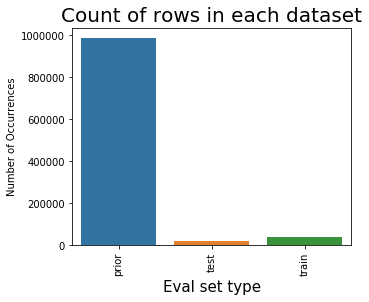

In [0]:
plt.figure(figsize= (5,4))
sns.barplot(cnt_df.index, cnt_df.values)
plt.ylabel('Number of Occurrences',fontsize = 10)
plt.xlabel('Eval set type', fontsize = 15)
plt.title('Count of rows in each dataset', fontsize = 20)
plt.xticks(rotation = 'vertical')
plt.show()

### 2. Feature Engineering

In [0]:
data_ = {'Product_Features': ['prod_average_cart_position','prod_orders','prod_reorder_probability', 'prod_reorder_times','prod_reorder_ratio','-','-','-','-'],
        'User_Features' : ['user_orders', 'user_period', 'user_mean_days_since_prior', 'user_total_products','user_reorder_ratio',
                            'user_distinct_products','user_reorder_ratio','user_distinct_products','user_average_basket'],
        'User_Products_interaction': ['up_orders','up_first_orders', 'up_last_orders','up_average_cart_position','up_order_rate',
                                      'up_orders_since_last_order','up_order_rate_since_first_order','-','-'],
        'Recency' : ['days_since_prior_order', '-','-','-','-','-','-','-','-']}

frame = pd.DataFrame(data_, index = [1,2,3,4,5,6,7,8,9])

In [0]:
frame

,Product_Features,User_Features,User_Products_interaction,Recency
1,prod_average_cart_position,user_orders,up_orders,days_since_prior_order
2,prod_orders,user_period,up_first_orders,-
3,prod_reorder_probability,user_mean_days_since_prior,up_last_orders,-
4,prod_reorder_times,user_total_products,up_average_cart_position,-
5,prod_reorder_ratio,user_reorder_ratio,up_order_rate,-
6,-,user_distinct_products,up_orders_since_last_order,-
7,-,user_reorder_ratio,up_order_rate_since_first_order,-
8,-,user_distinct_products,-,-
9,-,user_average_basket,-,-


#### (1) Product data reshaping (products + department + aisles)

In [0]:
df_products = pd.merge(left = products, right = dep, on = 'department_id', how = 'left')
goods = pd.merge(left = df_products, right = aisles, on = 'aisle_id', how = 'left')
goods.tail(3)

,product_id,aisle_id,department_id,department,aisle
49685,49686,112,3,bakery,bread
49686,49687,41,8,pets,cat food care
49687,49688,73,11,personal care,facial care


In [0]:
goods.drop(['department_id'], axis = 1, inplace = True)
goods.drop(['aisle_id'], axis = 1, inplace = True)
goods.tail(3)

,product_id,department,aisle
49685,49686,bakery,bread
49686,49687,pets,cat food care
49687,49688,personal care,facial care


#### (2) Product data (5)


1.Average of cart order (assuming the first to pick up, the more likely you are to repurchase)
2.Total order count (assuming the more orders, the higher the chance of repurchase)
3.Chance to Repurchase (Use Conditional Probability. (Second Order / First Order))
4.Average number of reorders (assuming the more reorders, the higher the chance of repurchase)
5.Repurchase rate of all orders

In [0]:
ord_prd_tr = ord_prd_tr.merge(orders[['user_id','order_id']], left_on = 'order_id', right_on = 'order_id', how = 'inner')

In [0]:
orders_products_pr = orders.merge(ord_prd_pr, how = 'inner', on = 'order_id')

In [0]:
# sorting orders and products to get the rank or the reorder times for the product
prdss = orders_products_pr.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)

In [0]:
prdot = orders_products_pr.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)

In [0]:
prdot.shape

(299786, 10)

In [0]:
# product time 
prdss = prdss.assign(product_time = prdss.groupby(['user_id', 'product_id']).cumcount()+1)

In [0]:
# prod_average_cart_position: 
sub = prdss.groupby(['product_id'])['add_to_cart_order'].mean().to_frame('prod_average_cart_position')

In [0]:
# getting products ordered first and second times 
# sub1: Number of first purchases per product 
# sub2: Second purchase per product
sub1 = prdss[prdss['product_time'] == 1].groupby('product_id').size().to_frame('prod_first_orders')
sub2 = prdss[prdss['product_time'] == 2].groupby('product_id').size().to_frame('prod_second_orders')

In [0]:
# sub1 prod_orders 
sub1['prod_orders'] = prdss.groupby('product_id')['product_id'].size()

In [0]:
# sub1 prod_reorders 
# prod_orders (total number of purchases per product) = prod_first_orders (first number of orders per product) + prod_reorders (repurchases per product)
sub1['prod_reorders'] = prdss.groupby('product_id')['reordered'].sum()

In [0]:
# sub1 and sub2 Merge
sub2 = sub2.reset_index().merge(sub1.reset_index())

In [0]:
print('sub2 {}: {}'.format(sub2.shape, ', '.join(sub2.columns)))

sub2 (5758, 5): product_id, prod_second_orders, prod_first_orders, prod_orders, prod_reorders


In [0]:
# calculating reorder probability and ratio for the product
# 'prod_reorder_probability' : Probability of repurchase by product (= second purchase per product / first purchase per product)
sub2['prod_reorder_probability'] = sub2['prod_second_orders']/sub2['prod_first_orders']

In [0]:
# 'prod_reorder_times' Average number of product reorders: 1 + (number of repurchases per product / first purchase per product)
sub2['prod_reorder_times'] = 1 + sub2['prod_reorders']/sub2['prod_first_orders']

In [0]:
# 'prod_reorder_ratio' repurchase rate = repurchases / total orders
sub2['prod_reorder_ratio'] = sub2['prod_reorders']/sub2['prod_orders']

In [0]:
prd = sub2[['product_id', 'prod_orders','prod_reorder_probability', 'prod_reorder_times', 'prod_reorder_ratio']]

In [0]:
# Memory cleaning 
del sub1, sub2
gc.collect()

2320

#### (3) User Data (7)


(Characteristic of user)

Total Order Count (how many orders)
The total of the period until the next order (how often do you order)
Average time to next order (how often do you order faster)
Total Ordered Products (how many orders)
Repurchase Rate (how much to reorder a particular product)
Type of product ordered (index) (how many different orders)
Average number of products per order (how many orders at a time)

In [0]:
# create user_orders-number of orders per user
users = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['order_number'].max().to_frame('user_orders')

In [0]:
print('users {}: {}'.format(users.shape, ', '.join(users.columns)))

users (63100, 1): user_orders


In [0]:
# create user_period-total order date since previous order
users['user_period'] = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['days_since_prior_order'].sum()

In [0]:
# create user_mean_days_since_prior-Average order days
users['user_mean_days_since_prior'] = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['days_since_prior_order'].mean()

In [0]:
# merging features about users and orders into one dataset
# create user_total_products-the number of products ordered by user id
us = orders_products_pr.groupby('user_id').size().to_frame('user_total_products')

In [0]:

# eq_1-number of products reordered
us['eq_1'] = orders_products_pr[orders_products_pr['reordered'] == 1].groupby('user_id')['product_id'].size()

In [0]:

# qt_1-the number of products of the order except the first order by user
us ['gt_1'] = orders_products_pr [orders_products_pr ['order_number']> 1] .groupby ('user_id') ['product_id']. size ()

In [0]:

# user_reorder_ratio: Repurchase rate by user (= number of products reordered / number of products in the order except first order)
us['user_reorder_ratio'] = us['eq_1'] / us['gt_1']

In [0]:
us.drop(['eq_1', 'gt_1'], axis = 1, inplace = True)

In [0]:
# user_distinct_products: Number of product types ordered by user
us['user_distinct_products'] = orders_products_pr.groupby(['user_id'])['product_id'].nunique()

In [0]:
# users and us combined
users = users.reset_index().merge(us.reset_index())

In [0]:
# user_average_basket : Average number of products per order per user
users['user_average_basket'] = users['user_total_products'] / users['user_orders']

In [0]:

# test, train order only ..
us2 = orders[orders['eval_set'] != 'prior'] 

In [0]:
us2 = us2[['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]

In [0]:
users = users.merge(us2)

In [0]:
print('users {}: {}'.format(users.shape, ', '.join(users.columns)))

users (20189, 11): user_id, user_orders, user_period, user_mean_days_since_prior, user_total_products, user_reorder_ratio, user_distinct_products, user_average_basket, order_id, eval_set, days_since_prior_order



(4) Order data (related with User & Product data) (7)
(Project goal: to find out whether the test user repurchases the last ordered product-> user and product complex feature required)

Total number of orders for a specific product by user
Order number of first order of a specific product by user
Last order order for a specific product by user
Average number of products in a shopping cart by user
The rate at which a particular user ordered a specific product (orders per user / product / total orders per user)
The number of orders for which a user has not had that product since the last time they ordered a particular product (the lower the value, the more recent purchase)
Order rate by user / product since first order

(From a given dataset) 1. Period from order to reorder

In [0]:
# up_orders: Orders per user, product
data = orders_products_pr.groupby(['user_id', 'product_id']).size().to_frame('up_orders')

In [0]:

# up_first_order: Order order that originally placed the product
data['up_first_order'] = orders_products_pr.groupby(['user_id', 'product_id'])['order_number'].min()

In [0]:
# up_last_order: Order order that originally placed the product
data['up_last_order'] = orders_products_pr.groupby(['user_id', 'product_id'])['order_number'].max()

In [0]:

# avg_cart_position: Average of the carted order by product # up_orders: Orders per user, product
data['up_average_cart_position'] = orders_products_pr.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean()
data = data.reset_index()

In [0]:
# combined with user, product data
data = data.merge(prd, on = 'product_id')
data = data.merge(users, on = 'user_id')

In [0]:
print('data {}: {}'.format(data.shape, ', '.join(data.columns)))

data (209046, 20): user_id, product_id, up_orders, up_first_order, up_last_order, up_average_cart_position, prod_orders, prod_reorder_probability, prod_reorder_times, prod_reorder_ratio, user_orders, user_period, user_mean_days_since_prior, user_total_products, user_reorder_ratio, user_distinct_products, user_average_basket, order_id, eval_set, days_since_prior_order


In [0]:

# up_order_rate Order Rate by User / Product: Order Count by User / Product / Total Order by User
data['up_order_rate'] = data['up_orders'] / data['user_orders']

In [0]:
# up_orders_since_last_order Number of user orders since last order by product: Total orders by user-Final orders by user / product
data['up_orders_since_last_order'] = data['user_orders'] - data['up_last_order']

In [0]:
# up_order_rate_since_first_order 
# Order rate by user / product after first order: Order by user / product / (Total order by user-Initial order by user / product + 1)
data['up_order_rate_since_first_order'] = data['up_orders'] / (data['user_orders'] - data['up_first_order'] + 1)

In [0]:

# reordered add
data = data.merge(ord_prd_tr[['user_id', 'product_id', 'reordered']], how = 'left', on = ['user_id', 'product_id'])

In [0]:
data.tail(3)

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_orders,user_period,user_mean_days_since_prior,user_total_products,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,reordered
209043,46120,16939.0,1,8,8,4.0,7,0.200000,1.600000,0.428571,13,235.0,19.583334,4,NaN,4,0.307692,477627,train,18.0,0.076923,5,0.166667,NaN
209044,58115,48175.0,1,2,2,1.0,4,0.333333,2.000000,0.750000,4,50.0,16.666666,1,1.0,1,0.250000,3212843,test,17.0,0.250000,2,0.333333,NaN
209045,51816,26924.0,1,6,6,1.0,5,0.333333,2.666667,1.000000,8,97.0,13.857142,2,1.0,2,0.250000,1449088,test,0.0,0.125000,2,0.333333,NaN


#### train, test dataset 

In [0]:
# create a train set
train = data[data['eval_set'] == 'train']

In [0]:
train ['reordered']. fillna (0, inplace = True) # replace with NaN 0
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis = 1, inplace = True) # Excluding features other than training feature

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [0]:
train.shape

(133030, 20)

In [0]:
train.columns

Index(['up_orders', 'up_first_order', 'up_last_order',
       'up_average_cart_position', 'prod_orders', 'prod_reorder_probability',
       'prod_reorder_times', 'prod_reorder_ratio', 'user_orders',
       'user_period', 'user_mean_days_since_prior', 'user_total_products',
       'user_reorder_ratio', 'user_distinct_products', 'user_average_basket',
       'days_since_prior_order', 'up_order_rate', 'up_orders_since_last_order',
       'up_order_rate_since_first_order', 'reordered'],
      dtype='object')

In [0]:
# filter by eval_set = test, replace Nan with zeros (not reordered) 
test = data[data['eval_set'] == 'test']
test['reordered'].fillna(0, inplace=True)
test.drop(['eval_set', 'user_id'], axis = 1, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [0]:
test.shape

(76016, 22)

In [0]:
# Saving train and test sets to files for easier loading to model, without having to re-prepare the data.
train.to_csv('my_train3.csv', header = True, index = False)
test.to_csv('my_test3.csv', header = True, index = False)

### 3. Model Selection & Evaluation & Prediction

In [0]:
# loading files
train = pd.read_csv('my_train3.csv')
test = pd.read_csv('my_test3.csv')

In [0]:
# Splitting the training set to train and validation set. Validation set 
from sklearn.model_selection import train_test_split
X_train, X_eval, y_train, y_eval = train_test_split(train[train.columns.difference(['reordered'])], train['reordered'], test_size=0.33, random_state=7)

* XGBoost do not require preprocessing (null value processing, scaling, etc.), so the model is returned immediately.

In [0]:

from sklearn.model_selection import GridSearchCV

In [0]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import graphviz

In [0]:
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_eval = xgb.DMatrix(X_eval, y_eval) 
# parameter link : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
xgb_params = {
    "objective"         : "binary:logistic" # loss function. binary:logistic (logistic regression for binary classification => predicted class) # multi:softmax (multicalss classification using the softmax objective -> predicted class , ) # multi:softprob: softmax return probability instead of class
    #,"num_class"        : 2                # If you use multi: softmax, you must set num_class (number of unique classes)
    ,"eval_metric"      : "auc"              # metric to be used for validation (type: rmse, mae, logloss, error, merror, mlogloss, auc)
    ,"eta"              : 0.1                # learning rate  to GBM (typically a value between 0.01 and 0.2)
    ,"max_depth"        : 6                  # maximum depth of a tree (Used to prevent overfitting. The larger the depth, the more specific the relationship is learned. Usually 3-10)
    ,"min_child_weight" : 10                 # minimum sum of weights of all observations (default=1, overfitting Use to prevent, if too high underfitting concern)
    ,"gamma"            : 0.70               # Minimum loss function for splitting, split only when decreasing above (default = 0)
    ,"subsample"        : 0.76                # The ratio of observations to random samples for each tree. Low value prevents conservative & overfitting. Too low, underfitting concerns (typically 0.5-1)
    ,"colsample_bytree" : 0.95                # The percentage of columns that will be random samples for each tree. (default 1, typically 0.5-1)
    ,"alpha"            : 2e-05               # L1 regularization term on weights (Lasso Regression) (default=0)
    ,"lambda"           :1                   # L2 regularization term on weights.(Ridge Regression) (default=1)
}

watchlist  = [(xgb_eval,'eval'), (xgb_train,'train')]

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [0]:
print('training XGBoost model ...')
xgb_model = xgb.train(params = xgb_params,
                dtrain = xgb_train,
                num_boost_round = 300,
                evals = (watchlist),
                verbose_eval=10)  # will stop the boost rounds if evaluation metricices didn't improve

training XGBoost model ...
[0]	eval-auc:0.66523	train-auc:0.676723
[10]	eval-auc:0.69289	train-auc:0.709939
[20]	eval-auc:0.698114	train-auc:0.720525
[30]	eval-auc:0.701603	train-auc:0.728656
[40]	eval-auc:0.705543	train-auc:0.736244
[50]	eval-auc:0.708199	train-auc:0.742738
[60]	eval-auc:0.711461	train-auc:0.749921
[70]	eval-auc:0.713368	train-auc:0.754926
[80]	eval-auc:0.715338	train-auc:0.759913
[90]	eval-auc:0.71648	train-auc:0.76391
[100]	eval-auc:0.717906	train-auc:0.769406
[110]	eval-auc:0.719619	train-auc:0.774164
[120]	eval-auc:0.721018	train-auc:0.777945
[130]	eval-auc:0.722469	train-auc:0.781967
[140]	eval-auc:0.724401	train-auc:0.787356
[150]	eval-auc:0.725924	train-auc:0.790786
[160]	eval-auc:0.727434	train-auc:0.795144
[170]	eval-auc:0.728172	train-auc:0.798737
[180]	eval-auc:0.728969	train-auc:0.802114
[190]	eval-auc:0.72948	train-auc:0.805042
[200]	eval-auc:0.730306	train-auc:0.808695
[210]	eval-auc:0.731282	train-auc:0.811943
[220]	eval-auc:0.732204	train-auc:0.814245


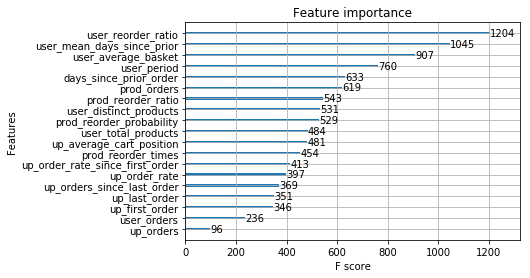

In [0]:
xgb.plot_importance(xgb_model)

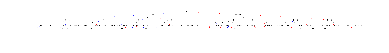

In [0]:
xgb.plot_tree(xgb_model, num_trees=1)

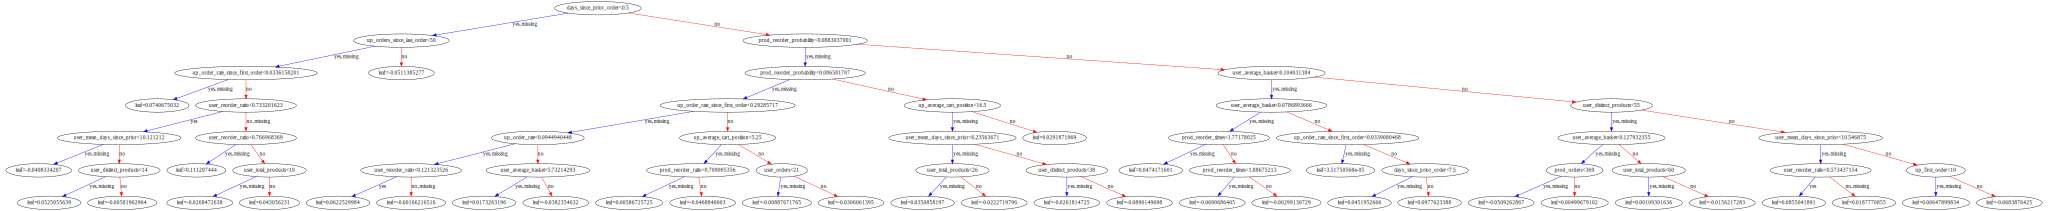

In [0]:
xgb.to_graphviz(xgb_model, num_trees=199)

In [0]:
X_test = test[test.columns.difference(['order_id', 'product_id'])]

In [0]:
X_test = X_test.drop(['reordered'], axis=1)

In [0]:
X_test.tail()

,days_since_prior_order,prod_orders,prod_reorder_probability,prod_reorder_ratio,prod_reorder_times,up_average_cart_position,up_first_order,up_last_order,up_order_rate,up_order_rate_since_first_order,up_orders,up_orders_since_last_order,user_average_basket,user_distinct_products,user_mean_days_since_prior,user_orders,user_period,user_reorder_ratio,user_total_products
76011,13.0,4,0.333333,0.75,2.000000,2.0,2,2,0.200000,0.250000,1,3,0.600000,3,13.750000,5,55.0,0.333333,3
76012,12.0,4,0.333333,0.75,2.000000,1.0,1,1,0.166667,0.166667,1,5,0.333333,2,10.400000,6,52.0,NaN,2
76013,30.0,4,1.000000,0.75,2.500000,1.0,1,19,0.048780,0.048780,2,22,0.048780,1,5.150000,41,206.0,1.000000,2
76014,17.0,4,0.333333,0.75,2.000000,1.0,2,2,0.250000,0.333333,1,2,0.250000,1,16.666666,4,50.0,1.000000,1
76015,0.0,5,0.333333,1.00,2.666667,1.0,6,6,0.125000,0.333333,1,2,0.250000,2,13.857142,8,97.0,1.000000,2


In [0]:
d_test = xgb.DMatrix(X_test)

In [0]:
test['reordered'] = xgb_model.predict(d_test)

In [0]:
test['reordered'].tail()

76011    0.214019
76012    0.315480
76013    0.265739
76014    0.561434
76015    0.365927
Name: reordered, dtype: float32

In [0]:
print('formatting and writing to submission file ...')
prd_bag = dict()
for row in test.itertuples():
    if row.reordered > 0.21:   ## Cutoff for lableing product as positive (can be tweaked with cross validation)
#    if row.reordered > 0.25: 
        try:
            prd_bag[row.order_id] += ' ' + str(row.product_id)
        except:
            prd_bag[row.order_id] = str(row.product_id)

for order in test.order_id:
    if order not in prd_bag:
        prd_bag[order] = 'None'

submit = pd.DataFrame.from_dict(prd_bag, orient='index')

submit.reset_index(inplace=True)
submit.columns = ['order_id', 'products']
submit.to_csv('xgboost_submit21.csv', index=False)

formatting and writing to submission file ...
